In [1]:
getwd() # working directory 
ls()    # currently nothing in my R workspace

[1] "/Users/dsp/dongmei/climate-space/notebooks"

character(0)

In [2]:
source('../R/damian/getPseudoDaily.R')  # load .R source file

# now the functions/objects in the file are available
ls()                                    

[1] "get.a.j"                "get.a.nought"           "get.b.j"               
[4] "get.daily.from.monthly" "interpolate.daily"

In [7]:
# Sample monthly means
monthly.means <- c(Jan=42, Feb=54, Mar=55, Apr=63, May=66, Jun=77, Jul=78, 
                   Aug=79, Sep=75, Oct=68, Nov=55, Dec=44)
monthly.lows <- monthly.means + rnorm(12, -10, 2)

winter.monthly.means <- c(Aug=79, Sep=75, Oct=68, Nov=55, Dec=44, Jan=42, 
                          Feb=54, Mar=55, Apr=63, May=66, Jun=77, Jul=78)
winter.monthly.lows <- monthly.lows[c(8:12, 1:7)]

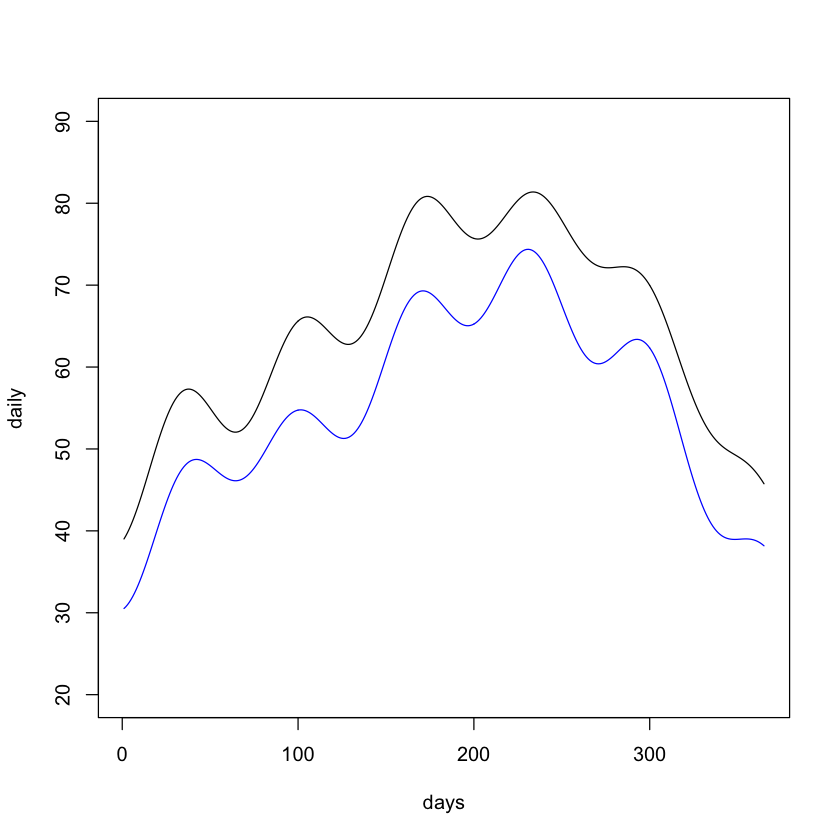

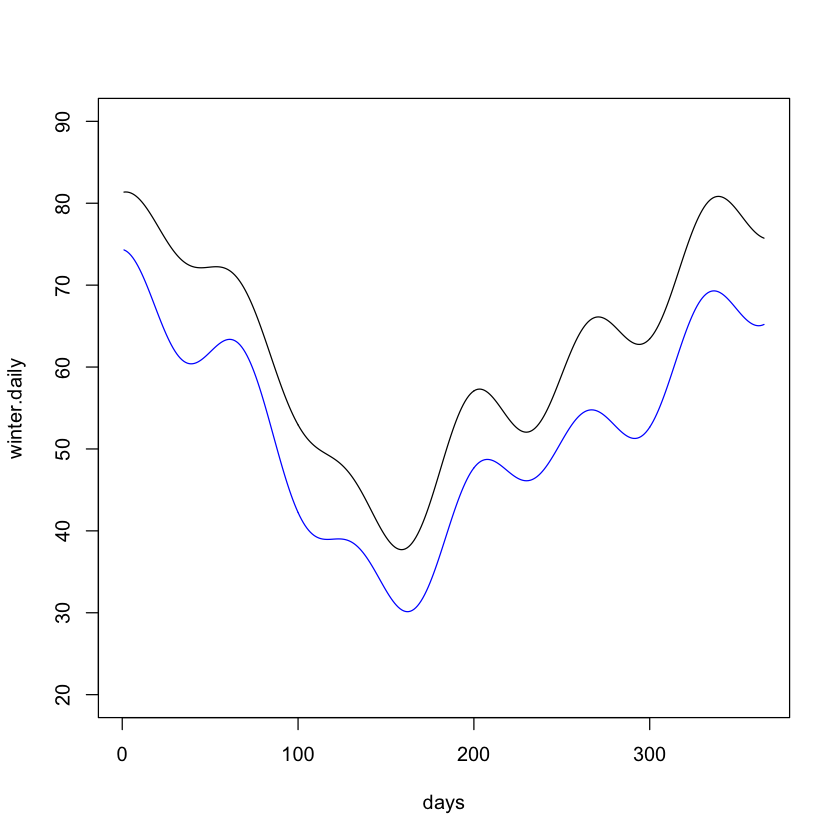

In [8]:
days <- 1:365
daily <- get.daily.from.monthly(monthly.means, n.days=365)
daily.lows <- get.daily.from.monthly(monthly.lows, n.days=365)
winter.daily <- get.daily.from.monthly(winter.monthly.means, n.days=365)
winter.daily.lows <- get.daily.from.monthly(winter.monthly.lows, 
                                            n.days=365)


plot(daily ~ days, type='l', ylim=c(20, 90))
lines(daily.lows ~ days, col=4)
plot(winter.daily ~ days, type='l', ylim=c(20, 90))
lines(winter.daily.lows ~ days, col=4)

In [9]:
get.month.start <- function(leap.year=F) {
  jan <- 1
  feb <- jan + 31
  mar <- ifelse(leap.year, feb + 29, feb + 28)
  apr <- mar + 31
  may <- apr + 30
  jun <- may + 31
  jul <- jun + 30
  aug <- jul + 31
  sep <- aug + 31
  oct <- sep + 30
  nov <- oct + 31
  dec <- nov + 30
  c(jan=jan, feb=feb, mar=mar, apr=apr, may=may, jun=jun, jul=jul, aug=aug,
    sep=sep, oct=oct, nov=nov, dec=dec)
}

In [12]:
month.start <- get.month.start()
month.start.ly <- get.month.start(leap.year=T)
winter.offset <- (month.start - 212) %% 365
winter.offset.ly <- (month.start.ly - 213) %% 366
month.starts <- cbind(normal=month.start, 
                      leap.year=month.start.ly, 
                      winter.normal=winter.offset,
                      winter.leap.year=winter.offset.ly)

month.starts

,normal,leap.year,winter.normal,winter.leap.year
jan,1,1,154,154
feb,32,32,185,185
mar,60,61,213,214
apr,91,92,244,245
may,121,122,274,275
jun,152,153,305,306
jul,182,183,335,336
aug,213,214,1,1
sep,244,245,32,32
oct,274,275,62,62


# Stats Derived from Daily Data

### Date Ranges Needed
* Oct 15 (t-1) - Nov 30 (t-1)
  * Ecs: earlyColdSnap
* Winter: Dec (t-1) - Feb (t)
  * winterTmin
  * Ncs: numberColdSnap
  * Acs: avgDurationColdSnap
  * drop0
  * drop5, 10, 15, 20, >20
  * maxdrop
  * min30, 32, 34, 36, 38, 40
* Mar 01 (t) - Apr 15 (t)
  * Lcs: lateColdSnap
* Aug (t-1) - Jun (t)
  * ddAugJun
* Aug (t-1) - Jul (t)
  * ddAugJul
* Aug (t)
  * maxAugT
* Jun (t) - Aug (t)  
  * summerT40

In [13]:
is.leap.year <- function(year) {
  ifelse(year %% 4 == 0 & year %% 100 != 0, T, F)
}

is.leap.year(1976)
is.leap.year(1977)
is.leap.year(2008)
is.leap.year(2000)

[1] TRUE

[1] FALSE

[1] TRUE

[1] FALSE

In [14]:
has.n.consecutive.trues <- function(x, n) {
  max.consec <- 0
  for (val in x) {
    if (val) {
      max.consec <- max.consec + 1
      if (max.consec >= n) {
        return (T)
      }
    } else {
      max.consec <- 0
    }
  }
  F
}

has.n.consecutive.trues(c(T, T, F, T, F, T, F, F, T, T), 3)
has.n.consecutive.trues(c(T, T, F, T, F, T, F, F, T, T, T), 3)

[1] FALSE

[1] TRUE

In [15]:
is.coldsnap <- function(year, daily, early.late) {
  if (early.late == 'early') {
    date.range <- 288:334
  } else {
    date.range <- 60:105
  }
  if (is.leap.year(year)) {
    date.range <- date.range + 1
  }
  period <- daily[date.range]
  period <- period <= -20
  has.n.consecutive.trues(period, 4)
}

In [17]:
#get.nonwinter.stats <- function(year, monthly.lows) {
#  n.days <- ifelse(is.leap.year(year), 366, 365)
#  daily.low <- get.daily.from.monthly(monthly.lows, n.days)
#  Ecs <- 1 * is.coldsnap(year, daily.low, 'early')
#  Lcs <- 1 * is.coldsnap(year, daily.low, 'late')
#  list(Ecs=Ecs, Lcs=Lcs)
#}

In [18]:
#get.nonwinter.stats(1976, monthly.lows)

In [71]:
get.coldsnap.data <- function(daily.lows) {
  n.coldsnap <- 0
  length.coldsnap <- c()
  below.neg20 <- daily.lows <= -20
  consec.days <- 0
  for (day in below.neg20) {
    if (day) {
      consec.days <- consec.days + 1
    } else {
      if (consec.days > 3) {
        n.coldsnap <- n.coldsnap + 1
        length.coldsnap <- c(length.coldsnap, consec.days)
        consec.days <- 0
      } else {
        consec.days <- 0
      }
    }
  }
  Acs <- ifelse(length(length.coldsnap), mean(length.coldsnap), 0)
  list(Ncs=n.coldsnap, Acs=Acs)
}

x <- c(
  -20, -20, -20, -20, 0, 0, -20, 0, -20, -20, -20, -20, -20, 0, -20, 0)
get.coldsnap.data(x)

$Ncs
[1] 2

$Acs
[1] 4.5

In [83]:
get.drop.stats <- function(daily.means) {
  daily.changes <- diff(daily.means)
  drop0 <- sum(daily.changes >= 0)
  drop5 <- sum(daily.changes < 0 & daily.changes >= -5)
  drop10 <- sum(daily.changes < -5 & daily.changes >= -10)
  drop15 <- sum(daily.changes < -10 & daily.changes >= -15)
  drop20 <- sum(daily.changes < -15 & daily.changes >= -20)
  drop20plus <- sum(daily.changes < -20)
  max.drop <- abs(min(daily.changes))
  list(drop0=drop0, drop5=drop5, drop10=drop10, drop15=drop15, 
       drop20=drop20, drop20plus=drop20plus, max.drop=max.drop)
}


x <- c(100, 95, 85, 70, 50, 25, 25, 25)
diff(x)
get.drop.stats(x)

[1]  -5 -10 -15 -20 -25   0   0

$drop0
[1] 2

$drop5
[1] 1

$drop10
[1] 1

$drop15
[1] 1

$drop20
[1] 1

$drop20plus
[1] 1

$max.drop
[1] 25

In [93]:
get.winter.stats <- function(
    year, winter.monthly.means, winter.monthly.lows) {
  # NOTE: assumes winter.monthly.means and winter.monthly.lows go from 
  # Jul y - Jun y+1
  n.days <- ifelse(is.leap.year(year), 366, 365)
  winter.daily.means <- get.daily.from.monthly(winter.monthly.means, n.days) 
  winter.daily.lows <- get.daily.from.monthly(winter.monthly.lows, n.days)

  data.range <- 154:243
  if (is.leap.year(year)) {
    data.range <- c(data.range, 244)
  }
  winter.means <- winter.daily.means[data.range]
  winter.lows <- winter.daily.lows[data.range]
  
  winterTmin <- min(winter.lows)
  coldsnap.data <- get.coldsnap.data(winter.lows)
  Ncs <- coldsnap.data$Ncs
  Acs <- coldsnap.data$Acs
  drop.data <- get.drop.stats(winter.means)
  drop0 <- drop.data$drop0
  drop5 <- drop.data$drop5
  drop10 <- drop.data$drop10
  drop15 <- drop.data$drop15 
  drop20 <- drop.data$drop20
  drop20plus <- drop.data$drop20plus
  max.drop <- drop.data$max.drop
  min30 <- sum(winter.lows <= -30)
  min32 <- sum(winter.lows <= -32)  
  min34 <- sum(winter.lows <= -34)
  min36 <- sum(winter.lows <= -36)
  min38 <- sum(winter.lows <= -38)
  min40 <- sum(winter.lows <= -40)  
    
  degree.day.range <- 
  list(winterTmin=winterTmin, Ncs=Ncs, Acs=Acs, drop0=drop0, drop5=drop5, 
       drop10=drop10, drop15=drop15, drop20=drop20, drop20plus=drop20plus,
       max.drop=max.drop, min30=min30, min32=min32, min34=min34, 
       min36=min36, min38=min38, min40=min40)
}

In [97]:
get.winter.stats(1976, winter.monthly.means, winter.monthly.lows)

$winterTmin
[1] 26.64399

$Ncs
[1] 0

$Acs
[1] 0

$drop0
[1] 44

$drop5
[1] 46

$drop10
[1] 0

$drop15
[1] 0

$drop20
[1] 0

$drop20plus
[1] 0

$max.drop
[1] 0.4197111

$min30
[1] 0

$min32
[1] 0

$min34
[1] 0

$min36
[1] 0

$min38
[1] 0

$min40
[1] 0